1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [1]:
import pandas as pd
N = 35000
d = pd.read_csv('data_000637.txt', header=0, nrows= N,  skiprows = 0)
d

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
34995,1,0,47,3869200515,2127,20
34996,1,0,80,3869200515,2128,19
34997,1,0,48,3869200515,2123,8
34998,1,1,48,3869200515,2285,16


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [5]:
x = max(d["BX_COUNTER"]) + 1   
print(x)

3564


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

In [10]:
d['ABSLUTE_TIME_NS'] = (d['ORBIT_CNT'] * x + d['BX_COUNTER']) * 25 + d['TDC_MEAS']* 25/30
d['ABSLUTE_TIME_NS'] = d['ABSLUTE_TIME_NS'] - min(d['ABSOLUTE_TIME_NS'])
d['ABSOLUTE_TIME_SERIES'] = pd.to_datetime(d['ABSLUTE_TIME_NS'], unit = 'ns')
d

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABSOLUTE_TIME_NS,ABSOLUTE_TIME_SERIES,ABSLUTE_TIME_NS
0,1,0,123,3869200167,2374,26,0.000000e+00,1970-01-04 23:45:45.734939071,3.447457e+14
1,1,0,124,3869200167,2374,27,8.125000e-01,1970-01-04 23:45:45.734939072,3.447457e+14
2,1,0,63,3869200167,2553,28,4.476625e+03,1970-01-04 23:45:45.734943548,3.447457e+14
3,1,0,64,3869200167,2558,19,4.594125e+03,1970-01-04 23:45:45.734943665,3.447457e+14
4,1,0,64,3869200167,2760,25,9.649125e+03,1970-01-04 23:45:45.734948720,3.447457e+14
...,...,...,...,...,...,...,...,...,...
34995,1,0,47,3869200515,2127,20,3.100062e+07,1970-01-04 23:45:45.765939691,3.447458e+14
34996,1,0,80,3869200515,2128,19,3.100064e+07,1970-01-04 23:45:45.765939715,3.447458e+14
34997,1,0,48,3869200515,2123,8,3.100051e+07,1970-01-04 23:45:45.765939581,3.447458e+14
34998,1,1,48,3869200515,2285,16,3.100457e+07,1970-01-04 23:45:45.765943638,3.447458e+14


4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [11]:
import datetime as dt
itime = dt.datetime.now()
print("Beginning:", itime)
#--
time =  d['TDC_MEAS'] *(25/30) + d['BX_COUNTER'] * 25 + d['ORBIT_CNT']*x*25
fTime = dt.datetime.now()
print("End time:", fTime)
print("Elapsd time:", (fTime - itime))

Beginning: 2023-11-22 20:08:01.252764
End time: 2023-11-22 20:08:01.254843
Elapsd time: 0:00:00.002079


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [14]:
x= d.groupby(['TDC_CHANNEL']).size().sort_values().iloc[-3:]
print("noissy channels:\n", x, "\n")

noissy channels:
 TDC_CHANNEL
63     1728
64     1768
139    2910
dtype: int64 



6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [16]:
y = d.groupby(['ORBIT_CNT']).size()
print(y)

ORBIT_CNT
3869200167     43
3869200168     85
3869200169    127
3869200170     98
3869200171    109
             ... 
3869200511     67
3869200512    105
3869200513    107
3869200514    125
3869200515     57
Length: 349, dtype: int64


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [19]:
uniqu_139 = d[d['TDC_CHANNEL']==139]['ORBIT_CNT'].nunique()
print("number of the chanels unique orbits:", uniqu_139, '\n')

number of the chanels unique orbits: 349 



8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [21]:
series1 = d[d['FPGA']==0].groupby(['TDC_CHANNEL']).size()
series2 = d[d['FPGA']==1].groupby(['TDC_CHANNEL']).size()
print("FPGA0 :\n", series1)
print('********')
print("FPGA1 :\n", series2)

FPGA0 :
 TDC_CHANNEL
1        29
2        38
3        34
4        46
5        42
       ... 
121     181
122     181
123     497
124     477
139    2034
Length: 118, dtype: int64
********
FPGA1 :
 TDC_CHANNEL
1      767
2      849
3      626
4      696
5      413
      ... 
125     17
126     16
127     36
128     37
139    876
Length: 127, dtype: int64


9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

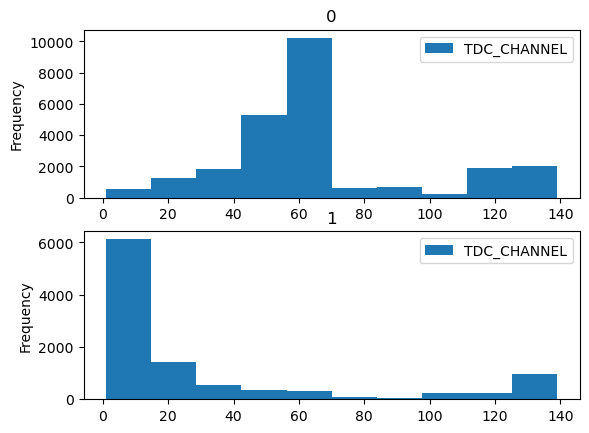

In [27]:
p = d.plot.hist(column=["TDC_CHANNEL"],by = "FPGA")